In [1]:
from pathlib import Path
import json

# Project paths
PROJECT    = Path("/scratch/qin.yife/Generative_Project")
OUT_DIR    = PROJECT / "outputs" / "m2_full"        # new clean folder for this redo
IMG_DIR    = OUT_DIR / "images"; IMG_DIR.mkdir(parents=True, exist_ok=True)
LOG_CSV    = PROJECT / "metrics" / "m2_full_runs.csv"
PROMPT_TXT = PROJECT / "outputs" / "m2" / "eval_prompts.txt"  # previously saved 8 prompts
MODEL_META = PROJECT / "outputs" / "m2" / "model_choice.json"

# Load prompts
with open(PROMPT_TXT, "r", encoding="utf-8") as f:
    PROMPTS = [ln.strip() for ln in f if ln.strip()]

# Parameter grid (CPU-friendly but complete across all prompts)
SCHEDULERS = ["DDIM", "DPMSolver"]      # two stable, fast-enough schedulers on CPU
CFG_LIST   = [5.0, 7.5, 10.0]           # typical sweep
STEPS      = 20                         # slightly higher than before for quality
BASE_SEED  = 20251114                   # per-prompt seed = BASE_SEED + idx
NEG_TEXT   = ("blurry, low quality, lowres, bad anatomy, deformed, distorted, extra limbs, extra fingers, "
              "text, watermark, logo, oversaturated, jpeg artifacts")

# Read model meta if available
used_model = "unknown"
try:
    used_model = json.loads(MODEL_META.read_text()).get("used_model", used_model)
except Exception:
    pass

# Plan summary
num_prompts = len(PROMPTS)
num_combos  = len(SCHEDULERS) * len(CFG_LIST)
total_imgs  = num_prompts * num_combos

print("=== FULL SWEEP PLAN ===")
print("Model        :", used_model)
print("Output dir   :", OUT_DIR)
print("Log CSV      :", LOG_CSV)
print("Prompts file :", PROMPT_TXT)
print("Prompts count:", num_prompts)
print("Schedulers   :", SCHEDULERS)
print("CFGs         :", CFG_LIST)
print("Steps        :", STEPS)
print("Seed rule    :", "seed = BASE_SEED + prompt_index  (BASE_SEED =", BASE_SEED, ")")
print("Negative txt :", NEG_TEXT[:90] + ("..." if len(NEG_TEXT)>90 else ""))
print("Total images :", f"{num_prompts} prompts × {num_combos} combos = {total_imgs}")

print("\nFirst 3 prompts preview:")
for i, p in enumerate(PROMPTS[:3], 1):
    print(f"{i:02d}. {p}")

print("\nPlanned combos (scheduler × cfg):")
for sch in SCHEDULERS:
    for cfg in CFG_LIST:
        print(f"- {sch:10s} | cfg={cfg}")

=== FULL SWEEP PLAN ===
Model        : runwayml/stable-diffusion-v1-5
Output dir   : /scratch/qin.yife/Generative_Project/outputs/m2_full
Log CSV      : /scratch/qin.yife/Generative_Project/metrics/m2_full_runs.csv
Prompts file : /scratch/qin.yife/Generative_Project/outputs/m2/eval_prompts.txt
Prompts count: 8
Schedulers   : ['DDIM', 'DPMSolver']
CFGs         : [5.0, 7.5, 10.0]
Steps        : 20
Seed rule    : seed = BASE_SEED + prompt_index  (BASE_SEED = 20251114 )
Negative txt : blurry, low quality, lowres, bad anatomy, deformed, distorted, extra limbs, extra fingers,...
Total images : 8 prompts × 6 combos = 48

First 3 prompts preview:
01. Two gray dogs run near the water on a manicured lawn in the fall .
02. Man in black wetsuit on his surfboard riding a blue wave with the beach and onlookers in the background .
03. Many people are clustered closely together , and several of them have alcohol .

Planned combos (scheduler × cfg):
- DDIM       | cfg=5.0
- DDIM       | cfg=7.5
- DDIM 

In [2]:
import os, json, torch
from pathlib import Path
from diffusers import StableDiffusionPipeline, DDIMScheduler

# Paths & env
PROJECT = Path("/scratch/qin.yife/Generative_Project")
OUT_DIR = PROJECT / "outputs" / "m2_full"; OUT_DIR.mkdir(parents=True, exist_ok=True)
os.environ["HF_HOME"] = str(PROJECT / ".cache" / "huggingface")
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "0"

# Device / dtype
device = "cuda" if torch.cuda.is_available() else "cpu"
dtype  = torch.float16 if device == "cuda" else torch.float32

# Load SD 1.5 and set DDIM as default scheduler
MODEL_ID = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(
    MODEL_ID, torch_dtype=dtype, cache_dir=os.environ["HF_HOME"], use_safetensors=True
)
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
try:
    pipe.enable_attention_slicing()
except Exception:
    pass
pipe = pipe.to(device)

# Save model meta for this redo
MODEL_META = OUT_DIR / "model_choice.json"
with open(MODEL_META, "w") as f:
    json.dump(
        {"used_model": MODEL_ID, "device": device, "dtype": str(dtype), "scheduler": type(pipe.scheduler).__name__},
        f, indent=2
    )

print("Loaded model:", MODEL_ID)
print("Scheduler   :", type(pipe.scheduler).__name__)
print("Device/dtype:", device, "/", dtype)
print("Text encoder:", pipe.text_encoder.__class__.__name__)
print("Tokenizer   :", getattr(pipe, "tokenizer", None).__class__.__name__)
print("HF_HOME     :", os.environ["HF_HOME"])
print("Saved model choice ->", MODEL_META)

2025-11-15 18:18:26.840103: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/home/qin.yife/.local/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loaded model: runwayml/stable-diffusion-v1-5
Scheduler   : DDIMScheduler
Device/dtype: cpu / torch.float32
Text encoder: CLIPTextModel
Tokenizer   : CLIPTokenizer
HF_HOME     : /scratch/qin.yife/Generative_Project/.cache/huggingface
Saved model choice -> /scratch/qin.yife/Generative_Project/outputs/m2_full/model_choice.json


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

steps,20,28,36
DPMSolver,"cfg=7.0, steps=20","cfg=7.0, steps=28","cfg=7.0, steps=36"
steps,20,28,36
DPMSolver,"cfg=7.0, steps=20","cfg=7.0, steps=28","cfg=7.0, steps=36"
steps,20,28,36
DPMSolver,"cfg=7.0, steps=20","cfg=7.0, steps=28","cfg=7.0, steps=36"
steps,20,28,36
DPMSolver,"cfg=7.0, steps=20","cfg=7.0, steps=28","cfg=7.0, steps=36"
steps,20,28,36
DPMSolver,"cfg=7.0, steps=20","cfg=7.0, steps=28","cfg=7.0, steps=36"
steps,20,28,36

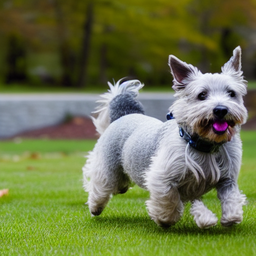
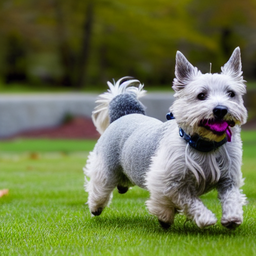
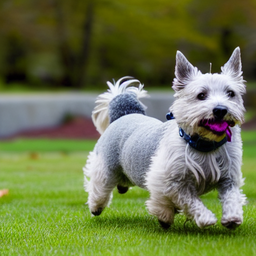
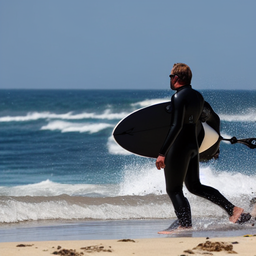
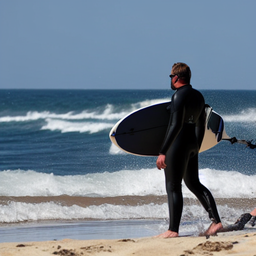
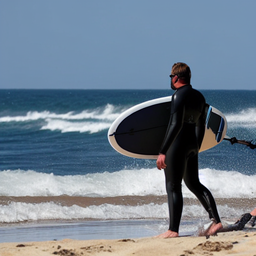
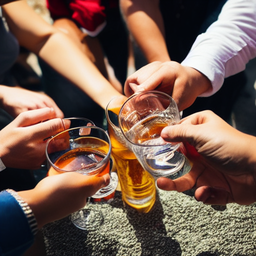
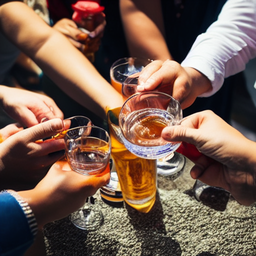
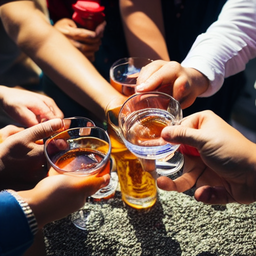
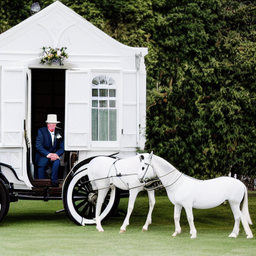
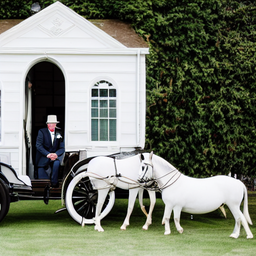
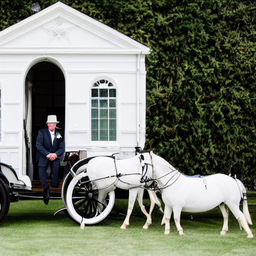
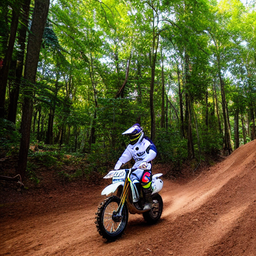
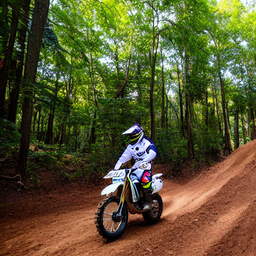
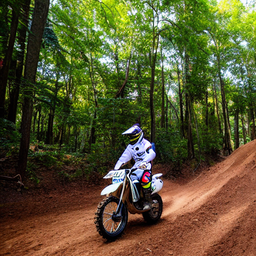
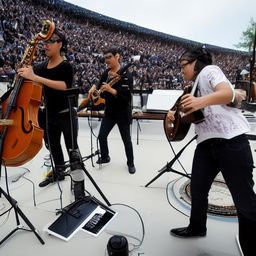
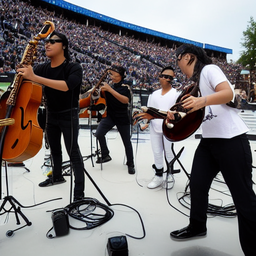
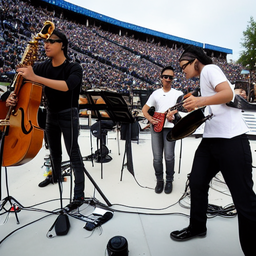
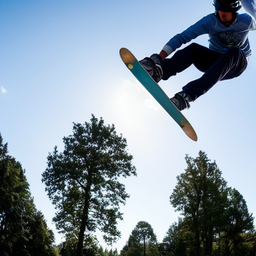
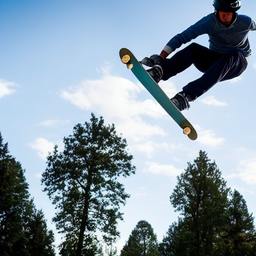
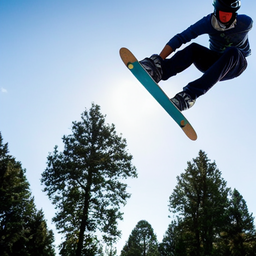
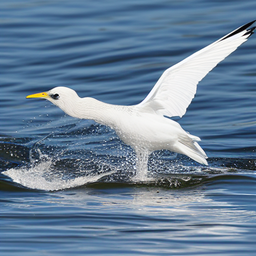
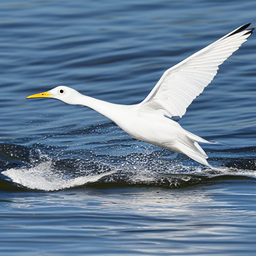
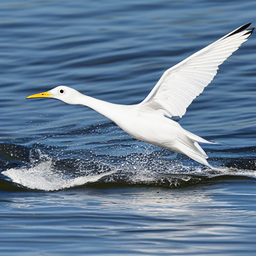

Generated new images: 24  |  Total expected (if none existed): 24
Images dir: /scratch/qin.yife/Generative_Project/outputs/m2_full_steps/images
Log path  : /scratch/qin.yife/Generative_Project/metrics/m2_steps_runs.csv


In [3]:
from pathlib import Path
import json, csv, re, io, base64
import torch
from PIL import Image
from IPython.display import display, HTML
from diffusers import DPMSolverMultistepScheduler

# Paths
PROJECT     = Path("/scratch/qin.yife/Generative_Project")
OUT_DIR     = PROJECT / "outputs" / "m2_full_steps"
IMG_DIR     = OUT_DIR / "images"; IMG_DIR.mkdir(parents=True, exist_ok=True)
LOG_CSV     = PROJECT / "metrics" / "m2_steps_runs.csv"
PROMPT_TXT  = PROJECT / "outputs" / "m2" / "eval_prompts.txt"
MODEL_META  = PROJECT / "outputs" / "m2_full" / "model_choice.json"

# Settings
STEPS_LIST  = [20, 28, 36]
CFG         = 7.0
BASE_SEED   = 20251114
NEG_TEXT    = ("blurry, low quality, lowres, bad anatomy, deformed, distorted, extra limbs, extra fingers, "
               "text, watermark, logo, oversaturated, jpeg artifacts")
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load prompts
with open(PROMPT_TXT, "r", encoding="utf-8") as f:
    PROMPTS = [ln.strip() for ln in f if ln.strip()]

# Meta
used_model = "unknown"
try:
    used_model = json.loads(MODEL_META.read_text()).get("used_model", used_model)
except Exception:
    pass

# Use DPMSolver
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

def slugify(text: str, max_len: int = 64):
    t = re.sub(r"[^A-Za-z0-9\s\-]+", "", text).strip()
    t = re.sub(r"\s+", " ", t)
    slug = t.lower().replace(" ", "-")
    if len(slug) > max_len: slug = slug[:max_len].rstrip("-")
    return slug or "prompt"

def img_to_uri(path: Path, max_w: int = 256) -> str:
    im = Image.open(path).convert("RGB")
    w, h = im.size
    if w > max_w:
        im = im.resize((max_w, int(h * (max_w / w))), Image.LANCZOS)
    buf = io.BytesIO(); im.save(buf, format="PNG", optimize=True)
    return "data:image/png;base64," + base64.b64encode(buf.getvalue()).decode("ascii")

# Prepare log writer (dedup by file path)
existing = set()
if LOG_CSV.exists():
    with open(LOG_CSV, "r", encoding="utf-8", newline="") as f:
        for r in csv.DictReader(f):
            if r.get("file"): existing.add(r["file"])
write_header = not LOG_CSV.exists()
log_f = open(LOG_CSV, "a", newline="", encoding="utf-8")
writer = csv.DictWriter(log_f, fieldnames=[
    "prompt_id","prompt","prompt_slug",
    "scheduler","guidance_scale","steps","seed","negative_prompt",
    "file","model"
])
if write_header: writer.writeheader()

# Generate or reuse, then display per-prompt panel (columns = steps)
style = """
<style>
.tbl { border-collapse: collapse; margin: 16px 0; }
.tbl th, .tbl td { border: 1px solid #ddd; padding: 6px 8px; text-align: center; }
.tbl th { background: #f7f7f7; }
.prompt { font-weight: 600; margin: 8px 0 4px; }
.cap { font-size: 12px; color: #444; }
</style>
"""
sections = [style]
generated = 0

for pid, prompt in enumerate(PROMPTS, start=1):
    seed = BASE_SEED + pid
    pslug = f"p{pid:02d}_" + slugify(prompt, 48)

    # Row header
    html = [f'<div class="prompt">{pid:02d}. {prompt}</div>']
    html.append("<table class='tbl'><tr><th>steps</th>" + "".join(f"<th>{s}</th>" for s in STEPS_LIST) + "</tr>")

    row = ["<td><b>DPMSolver</b></td>"]
    for steps in STEPS_LIST:
        fname = f"{pslug}_sch-DPMSolver_cfg-{CFG}_s-{steps}_seed-{seed}.png"
        fpath = IMG_DIR / fname
        if not fpath.exists():
            gen = torch.Generator(device=device).manual_seed(seed)
            img = pipe(
                prompt,
                negative_prompt=NEG_TEXT,
                num_inference_steps=steps,
                guidance_scale=CFG,
                guidance_rescale=0.7,
                generator=gen
            ).images[0]
            img.save(fpath)
            generated += 1

        if str(fpath) not in existing:
            writer.writerow({
                "prompt_id": f"{pid:02d}",
                "prompt": prompt,
                "prompt_slug": pslug,
                "scheduler": "DPMSolver",
                "guidance_scale": CFG,
                "steps": steps,
                "seed": seed,
                "negative_prompt": NEG_TEXT,
                "file": str(fpath),
                "model": used_model
            })
            existing.add(str(fpath))

        uri = img_to_uri(fpath, 256)
        row.append(f'<td><img src="{uri}"><div class="cap">cfg={CFG}, steps={steps}</div></td>')

    html.append("<tr>" + "".join(row) + "</tr>")
    html.append("</table>")
    sections.append("\n".join(html))

log_f.close()
display(HTML("\n".join(sections)))

print(f"Generated new images: {generated}  |  Total expected (if none existed): {len(PROMPTS)*len(STEPS_LIST)}")
print("Images dir:", IMG_DIR)
print("Log path  :", LOG_CSV)